Matplotlib is building the font cache; this may take a moment.


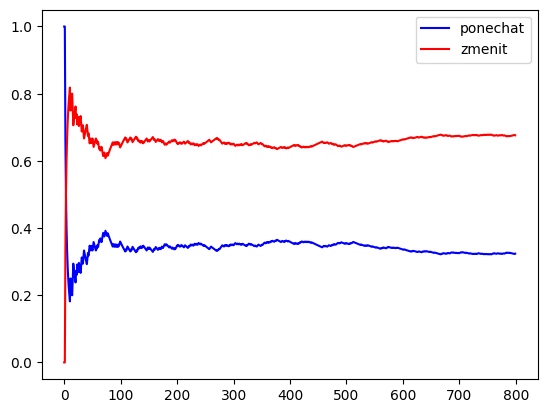

Šance na výhru změnou výběru:  0.67625
Šance na výhru ponecháním výběru:  0.32375


In [4]:
from random import shuffle, choice
import matplotlib.pyplot as plt

def MC_monty_hall(pocet_iteraci):
    pravdepodobnost_vyhry_ponechat = []
    pravdepodobnost_vyhry_zmenit = []
    pocet_vyher_zmena = 0                 # kolikrát vyhrajeme, pokud změníme dveře
    pocet_vyher_ponechani = 0             # kolikrát vyhrajeme, pokud nezměníme dveře

    for iterace in range(pocet_iteraci):
        dvere = ["koza", "koza", "auto"]
        shuffle(dvere)                          # zamíchání
        volba = dvere.index(choice(dvere))      # index náhodného výběru
        puvodni_volba = dvere.pop(volba)
        # díky rozmíchání shufflem není nutné vybírat pomocí choice, stačil by pop
        # ale modelujeme spravně celý proces v hlavě hráče
        
        volba_moderator = dvere.pop(dvere.index("koza"))    # ze zbývajících dveří otevře jedny s kozou
        
        # lze to napsat do jednoho příkazu celé, ale pak to již nebude tak explicitní :)
        zmena = choice(["ano", "ne"])
        if zmena == "ano":               # změna
            if puvodni_volba == "koza":       # původně měl kozu
                pocet_vyher_zmena += 1            # vyhraje auto
            elif puvodni_volba == "auto":
                pocet_vyher_ponechani += 1        # dostane kozu
        elif zmena == "ne":              # beze změny
            if puvodni_volba == "auto":       # původně měl mít auto
                pocet_vyher_ponechani += 1        # dostane auto
            elif puvodni_volba == "koza":
                pocet_vyher_zmena += 1            # dostane kozu
        
        pravdepodobnost_vyhry_zmenit.append(pocet_vyher_zmena/(iterace+1))
        pravdepodobnost_vyhry_ponechat.append(pocet_vyher_ponechani/(iterace+1))
    
    plt.plot(pravdepodobnost_vyhry_ponechat, "b", label="ponechat")
    plt.plot(pravdepodobnost_vyhry_zmenit, "r", label="zmenit")
    plt.legend()
    plt.show()
    print("Šance na výhru změnou výběru: ", pravdepodobnost_vyhry_zmenit[-1])
    print("Šance na výhru ponecháním výběru: ", pravdepodobnost_vyhry_ponechat[-1])

MC_monty_hall(800)

"""Jednoduché numerické modely úloh z dokumentu `msw_zapocet_2025.pdf`.

Modul je psán v objektově orientovaném stylu a obsahuje:
- `EulerIntegrator` -- nejjednodušší metoda integrace obyčejných dif.
  rovnic (ODE) pomocí Eulerovy metody,
- `ODEModel` -- společná třída pro konkrétní modely,
- `SIRModel`, `LotkaVolterraCompetitor` a `ZombieModel` -- realizace
daných úloh.

Všechny popisy a komentáře jsou v češtině.
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Callable, List, Tuple


class EulerIntegrator:
    """Jednoduchý Eulerův integrátor."""

    def __init__(self, dt: float = 0.1) -> None:
        self.dt = dt

    def solve(
        self,
        derivs: Callable[[List[float], float], List[float]],
        y0: List[float],
        t0: float,
        t_end: float,
    ) -> Tuple[List[float], List[List[float]]]:
        """Numerické řešení systému ODE.

        Parametry:
            derivs: funkce vracející derivace stavu
            y0: počáteční stav
            t0: počáteční čas
            t_end: koncový čas
        """
        t = t0
        y = y0[:]
        times = [t]
        states = [y[:]]
        while t < t_end:
            dy = derivs(y, t)
            y = [yi + self.dt * dyi for yi, dyi in zip(y, dy)]
            t += self.dt
            times.append(t)
            states.append(y[:])
        return times, states


class ODEModel:
    """Základní třída pro modely řešené Eulerovým integrátorem."""

    def __init__(self, dt: float = 0.1) -> None:
        self.integrator = EulerIntegrator(dt)

    def initial_state(self) -> List[float]:
        raise NotImplementedError

    def derivatives(self, state: List[float], t: float) -> List[float]:
        raise NotImplementedError

    def simulate(self, t_end: float) -> Tuple[List[float], List[List[float]]]:
        """Spustí simulaci od času 0 do `t_end`."""
        return self.integrator.solve(self.derivatives, self.initial_state(), 0.0, t_end)


@dataclass
class SIRModel(ODEModel):
    """Jednoduchý epidemiologický model SIR."""

    beta: float  # míra nakažlivosti
    gamma: float  # rychlost uzdravení
    s0: float  # počáteční počet náchylných
    i0: float  # počáteční počet nakažených
    r0: float  # počáteční počet zotavených
    dt: float = 0.1

    def __post_init__(self) -> None:
        super().__init__(self.dt)
        self.N = self.s0 + self.i0 + self.r0

    def initial_state(self) -> List[float]:
        return [self.s0, self.i0, self.r0]

    def derivatives(self, y: List[float], _t: float) -> List[float]:
        s, i, r = y
        ds = -self.beta * s * i / self.N
        di = self.beta * s * i / self.N - self.gamma * i
        dr = self.gamma * i
        return [ds, di, dr]


@dataclass
class LotkaVolterraCompetitor(ODEModel):
    """Model dravec-kořist rozšířený o konkurenční druh."""

    alpha: float
    beta: float
    delta: float
    gamma: float
    prey0: float
    pred0: float
    comp_rate: float  # rychlost růstu konkurenta
    comp0: float
    dt: float = 0.1

    def __post_init__(self) -> None:
        super().__init__(self.dt)

    def initial_state(self) -> List[float]:
        return [self.prey0, self.pred0, self.comp0]

    def derivatives(self, y: List[float], _t: float) -> List[float]:
        prey, pred, comp = y
        dprey = self.alpha * prey - self.beta * prey * (pred + comp)
        dpred = self.delta * prey * pred - self.gamma * pred
        dcomp = self.comp_rate * prey * comp - self.gamma * comp
        return [dprey, dpred, dcomp]


@dataclass
class ZombieModel(ODEModel):
    """Zjednodušený model zombie apokalypsy."""

    beta: float  # rychlost nákazy
    alpha: float  # schopnost přeživších ničit zombie
    rho: float  # rychlost vzkříšení
    s0: float
    z0: float
    r0: float
    dt: float = 0.1

    def __post_init__(self) -> None:
        super().__init__(self.dt)

    def initial_state(self) -> List[float]:
        return [self.s0, self.z0, self.r0]

    def derivatives(self, y: List[float], _t: float) -> List[float]:
        s, z, r = y
        ds = -self.beta * s * z - self.alpha * s * z
        dz = self.beta * s * z + self.rho * r - self.alpha * s * z
        dr = self.alpha * s * z - self.rho * r
        return [ds, dz, dr]


if __name__ == "__main__":
    # Příklad použití jednotlivých modelů
    sir = SIRModel(beta=0.3, gamma=0.1, s0=990, i0=10, r0=0)
    t, y = sir.simulate(160)
    print("Konec SIR:", y[-1])

    lv = LotkaVolterraCompetitor(
        alpha=1.0,
        beta=0.1,
        delta=0.075,
        gamma=1.5,
        prey0=40,
        pred0=9,
        comp_rate=0.05,
        comp0=5,
    )
    t, y = lv.simulate(50)
    print("Konec LV:", y[-1])

    zm = ZombieModel(beta=0.02, alpha=0.01, rho=0.005, s0=500, z0=1, r0=0)
    t, y = zm.simulate(100)
    print("Konec zombie:", y[-1])
    

In [ ]:
"""Jednoduché numerické modely úloh z dokumentu `msw_zapocet_2025.pdf`.

Modul je psán v objektově orientovaném stylu a obsahuje:
- `EulerIntegrator` -- nejjednodušší metoda integrace obyčejných dif.
  rovnic (ODE) pomocí Eulerovy metody,
- `ODEModel` -- společná třída pro konkrétní modely,
- `SIRModel`, `LotkaVolterraCompetitor` a `ZombieModel` -- realizace
daných úloh.

Všechny popisy a komentáře jsou v češtině.
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Callable, List, Tuple


class EulerIntegrator:
    """Jednoduchý Eulerův integrátor."""

    def __init__(self, dt: float = 0.1) -> None:
        self.dt = dt

    def solve(
        self,
        derivs: Callable[[List[float], float], List[float]],
        y0: List[float],
        t0: float,
        t_end: float,
    ) -> Tuple[List[float], List[List[float]]]:
        """Numerické řešení systému ODE.

        Parametry:
            derivs: funkce vracející derivace stavu
            y0: počáteční stav
            t0: počáteční čas
            t_end: koncový čas
        """
        t = t0
        y = y0[:]
        times = [t]
        states = [y[:]]
        while t < t_end:
            dy = derivs(y, t)
            y = [yi + self.dt * dyi for yi, dyi in zip(y, dy)]
            t += self.dt
            times.append(t)
            states.append(y[:])
        return times, states


class ODEModel:
    """Základní třída pro modely řešené Eulerovým integrátorem."""

    def __init__(self, dt: float = 0.1) -> None:
        self.integrator = EulerIntegrator(dt)

    def initial_state(self) -> List[float]:
        raise NotImplementedError

    def derivatives(self, state: List[float], t: float) -> List[float]:
        raise NotImplementedError

    def simulate(self, t_end: float) -> Tuple[List[float], List[List[float]]]:
        """Spustí simulaci od času 0 do `t_end`."""
        return self.integrator.solve(self.derivatives, self.initial_state(), 0.0, t_end)


@dataclass
class SIRModel(ODEModel):
    """Jednoduchý epidemiologický model SIR."""

    beta: float  # míra nakažlivosti
    gamma: float  # rychlost uzdravení
    s0: float  # počáteční počet náchylných
    i0: float  # počáteční počet nakažených
    r0: float  # počáteční počet zotavených
    dt: float = 0.1

    def __post_init__(self) -> None:
        super().__init__(self.dt)
        self.N = self.s0 + self.i0 + self.r0

    def initial_state(self) -> List[float]:
        return [self.s0, self.i0, self.r0]

    def derivatives(self, y: List[float], _t: float) -> List[float]:
        s, i, r = y
        ds = -self.beta * s * i / self.N
        di = self.beta * s * i / self.N - self.gamma * i
        dr = self.gamma * i
        return [ds, di, dr]


@dataclass
class LotkaVolterraCompetitor(ODEModel):
    """Model dravec-kořist rozšířený o konkurenční druh."""

    alpha: float
    beta: float
    delta: float
    gamma: float
    prey0: float
    pred0: float
    comp_rate: float  # rychlost růstu konkurenta
    comp0: float
    dt: float = 0.1

    def __post_init__(self) -> None:
        super().__init__(self.dt)

    def initial_state(self) -> List[float]:
        return [self.prey0, self.pred0, self.comp0]

    def derivatives(self, y: List[float], _t: float) -> List[float]:
        prey, pred, comp = y
        dprey = self.alpha * prey - self.beta * prey * (pred + comp)
        dpred = self.delta * prey * pred - self.gamma * pred
        dcomp = self.comp_rate * prey * comp - self.gamma * comp
        return [dprey, dpred, dcomp]


@dataclass
class ZombieModel(ODEModel):
    """Zjednodušený model zombie apokalypsy."""

    beta: float  # rychlost nákazy
    alpha: float  # schopnost přeživších ničit zombie
    rho: float  # rychlost vzkříšení
    s0: float
    z0: float
    r0: float
    dt: float = 0.1

    def __post_init__(self) -> None:
        super().__init__(self.dt)

    def initial_state(self) -> List[float]:
        return [self.s0, self.z0, self.r0]

    def derivatives(self, y: List[float], _t: float) -> List[float]:
        s, z, r = y
        ds = -self.beta * s * z - self.alpha * s * z
        dz = self.beta * s * z + self.rho * r - self.alpha * s * z
        dr = self.alpha * s * z - self.rho * r
        return [ds, dz, dr]


if __name__ == "__main__":
    # Příklad použití jednotlivých modelů
    sir = SIRModel(beta=0.3, gamma=0.1, s0=990, i0=10, r0=0)
    t, y = sir.simulate(160)
    print("Konec SIR:", y[-1])

    lv = LotkaVolterraCompetitor(
        alpha=1.0,
        beta=0.1,
        delta=0.075,
        gamma=1.5,
        prey0=40,
        pred0=9,
        comp_rate=0.05,
        comp0=5,
    )
    t, y = lv.simulate(50)
    print("Konec LV:", y[-1])

    zm = ZombieModel(beta=0.02, alpha=0.01, rho=0.005, s0=500, z0=1, r0=0)
    t, y = zm.simulate(100)
    print("Konec zombie:", y[-1])
    
    

Konec SIR: [58.194388010245326, 0.010421714296361994, 941.7951902754579]
Konec LV: [-5.162881810631028, 1.4959694072372548e-09, 6.87703935096554e-17]
Konec zombie: [3e-323, 232.68766680029364, 101.64566653303982]
